{/* cspell:ignore pfmap backgroundcolor linesize, imshow, minpos, nonumber, zzcircuit, zcircuit, pcircuit, zzcx, Schuld, Francesco, Petruccione, Vojtech, Adrian, Perez, Cervera, Lierta, Elies, Fuster, Jose, Latorre, Sweke, Jakob, Adrián, Pérez-Salinas, Alba, Cervera-Lierta, Elies, Gil-Fuster, José */}

# Data encoding

## Introduction and notation

To use a quantum algorithm, classical data must somehow be brought into a quantum circuit. This is usually referred to as data *encoding*, but is also called data *loading*. Recall from previous lessons the notion of a feature mapping, a mapping of data features from one space to another. Just transferring classical data to a quantum computer is a sort of mapping, and could be called a feature mapping. In practice, the built-in feature mappings in Qiskit (like \`z\_Feature Map and ZZ Feature Map) will typically include rotation layers and entangling layers that extend the state to many dimensions in the Hilbert space. This encoding process is a critical part of quantum machine learning algorithms and directly affects their computational capabilities.

Some of the encoding techniques below can be efficiently classically simulated; this is particularly easy to see in encoding methods that yield product states (that is, they do not entangle qubits). And remember that quantum utility is most likely to lie where the quantum-like complexity of the dataset is well-matched by the encoding method. So it is very likely that you will end up writing your own encoding circuits. Here, we show a wide variety of possible encoding strategies simply so that you can compare and contrast them, and see what is possible. There are some very general statements that can be made about the usefulness of encoding techniques. For example, `efficient_su2` (see below) with a full entangling scheme is much more likely to capture quantum features of data than methods that yield product states  (like `z_feature_map`). But this does not mean `efficient_su2` is sufficient, or sufficiently well-matched to your dataset, to yield a quantum speed-up. That requires careful consideration of the structure of the data being modeled or classified. There is also a balancing act with circuit depth, since many feature maps which fully entangle the qubits in a circuit yield very deep circuits, too deep to get usable results on today's quantum computers.

### Notation

A dataset is a set of $M$ data vectors: $\text{X} = \{\vec{x}^{(j)}\,|\,j\in [M]\}$, where each vector is $N$ dimensional, that is, $\vec{x}^{(j)}=(\vec{x}^{(j)}_1,\ldots,\vec{x}^{(j)}_N)\in\mathbb{R}^N$. This could be extended to complex data features. In this lesson, we may occasionally use these notations for the full set $(\text{X}),$ and its specific elements like $\vec{x}^{(j)}$. But we will mostly refer to the loading of a single vector from our dataset at a time, and will often simply refer to a single vector of $N$ features as $\vec{x}$.

Additionally, it is common to use the symbol $\Phi(\vec{x})$ to refer to the feature mapping $\Phi$ of data vector $\vec{x}$. In quantum computing specifically, it is common to refer to mappings in quantum computing using $U(\vec{x}),$ a notation that reinforces the unitary nature of these operations. One could correctly use the same symbol for both; both are feature mappings. Throughout this course, we tend to use:

*   $\Phi(\vec{x})$ when discussing feature mappings in machine learning, generally, and
*   $U(\vec{x})$ when discussing circuit implementations of feature mappings.

### Normalization and information loss

In classical machine learning, training data features are often "normalized" or rescaled which often improves model performance. One common way of doing this is by using min-max normalization or standardization. In min-max normalization, feature columns of the data matrix $\text{X}$ (say, feature $k$) are normalized:

$$
x^{'(i)}_k = \frac{x^{(i)}_k - \text{min}\{x^{(j)}_k\,|\,\vec{x}^{(j)}\in [\text{X}]\}}{\text{max}\{x^{(j)}_k\,|\,\vec{x}^{(j)}\in [\text{X}]\}-\text{min}\{x^{(j)}_k\,|\,\vec{x}^{(j)}\in [\text{X}]\}}
$$

where min and max refer to the minimum and maximum of feature $k$ over the $M$ data vectors in the dataset $\text{X}$. All the feature values then fall in the unit interval: $x^{'(i)}_k \in [0,1]$ for all $i\in [M]$, $k\in[N]$.

Normalization is also a fundamental concept in quantum mechanics and quantum computing, but it is slightly different from min-max normalization. Normalization in quantum mechanics requires that the length (in the context of quantum computing, the 2-norm) of a state vector $|\psi\rangle$ is equal to unity: $\|\psi\|=\sqrt{\langle\psi|\psi\rangle} = 1$, ensuring that measurement probabilities sum to 1. The state is normalized by dividing by the 2-norm; that is, by rescaling

$$
|\psi\rangle\rightarrow\|\psi\|^{-1}|\psi\rangle
$$

In quantum computing and quantum mechanics, this is not a normalization imposed by people on the data, but a fundamental property of quantum states. Depending on your encoding scheme, this constraint may affect how your data are rescaled. For example, in amplitude encoding (see below), the data vector is normalized $\vert\vec{x}^{(j)}\vert = 1$ as is required by quantum mechanics, and this affects the scaling of the data being encoded. In phase encoding, feature values are recommended to be rescaled as $\vec{x}^{(j)}_i \in (0,2\pi]$ so that there is no information loss due to the modulo-$2\pi$ effect of encoding to a qubit phase angle[\[1,2\]](#references).



## Methods of encoding

In the next few sections, we will refer to a small example classical dataset $\text{X}_\text{ex}$ consisting of $M=5$ data vectors, each with $N=3$ features:

$$
\text{X}_{\text{ex}}=\{(4,8,5),(9,8,6),(2,9,2),(5,7,0),(3,7,5)\}
$$

In the notation introduced above, we might say the $1^\text{st}$ feature of the $4^\text{th}$ data vector in our set $\text{X}_{\text{ex}}$ is $\vec{x}^{(4)}_1 = 5,$ for example.



### Basis encoding

Basis encoding encodes a classical $P$-bit string into a computational basis state of a $P$-qubit system. Take for example $\vec{x}^{(1)}_3 = 5 = 0(2^3)+1(2^2)+0(2^1)+1(2^0).$ This can be represented as a $4$-bit string as $(0101)$, and by a $4$-qubit system as the quantum state $|0101\rangle$. More generally, for a $P$-bit string: $\vec{x}^{(j)}_k = (b_1, b_2, ... , b_P)$, the corresponding $P$-qubit state is $|x^{(j)}_k\rangle = | b_1, b_2, ... , b_P \rangle$ with $b_n \in \{0,1\}$ for $n = 1 , \dots , P$. Note that this is just for a single feature.

Basis encoding in quantum computing represents each classical bit as a separate qubit, mapping the binary representation of data directly onto quantum states in the computational basis. When multiple features need to be encoded, each feature is first converted to its binary form and then assigned to a distinct group of qubits — one group per feature — where each qubit reflects a bit in the binary representation of that feature.

As an example, let us encode the vector (5, 7, 0).

Suppose all features are stored in four bits (more than we need, but enough to represent any integer that is single-digit in base 10):

5 → binary 0101

7 → binary 0111

0 → binary 0000

These bit strings are assigned to three sets of four qubits, so the overall 12-qubit basis state is:

$$
∣0101 0111 0000⟩
$$

Here, the first four qubits represent the first feature, the next four qubits the second feature, and the last four qubits the third feature. The code below converts the data vector (5,7,0) to a quantum state, and is generalized to do so for other single-digit features.



In [1]:
from qiskit import QuantumCircuit

# Data point to encode
x = 5  # binary: 0101
y = 7  # binary: 0111
z = 0  # binary: 0000

# Convert each to 4-bit binary list
x_bits = [int(b) for b in format(x, "04b")]  # [0,1,0,1]
y_bits = [int(b) for b in format(y, "04b")]  # [0,1,1,1]
z_bits = [int(b) for b in format(z, "04b")]  # [0,0,0,0]

# Combine all bits
all_bits = x_bits + y_bits + z_bits  # [0,1,0,1,0,1,1,1,0,0,0,0]

# Initialize a 12-qubit quantum circuit
qc = QuantumCircuit(12)

# Apply x-gates where the bit is 1
for idx, bit in enumerate(all_bits):
    if bit == 1:
        qc.x(idx)

qc.draw("mpl")

<Image src="/learning/images/courses/quantum-machine-learning/data-encoding/extracted-outputs/85ee995f-1e50-4860-a24c-16bbc8b5c8b0-0.avif" alt="Output of the previous code cell" />

### Practice 

Features are to be encoded:  7 8 9
 4 Bit binary list [0, 1, 1, 1] [1, 0, 0, 0] [1, 0, 0, 1]


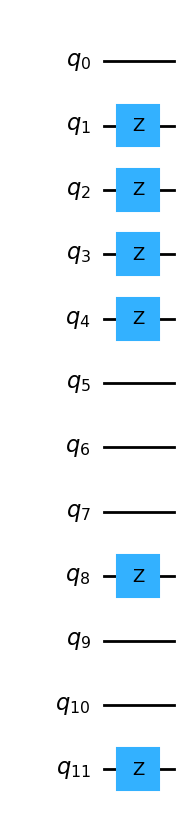

In [3]:
from qiskit import QuantumCircuit

# Data point to encode
X = 7 # Binary 0111
Y = 8 # Binary 1000
Z = 9 # Binary 1001
print("Features are to be encoded: ", X, Y,Z)

# Converting each to 4 bit binary list
x_bits = [int(b) for b in format(X,"04b")] # [0,1,1,1]
y_bits = [int(b) for b in format(Y,"04b")] # [1,0,0,0]
z_bits = [int(b) for b in format(Z,"04b")] # [1,0,0,1]


print(" 4 Bit binary list", x_bits, y_bits, z_bits)

# combine all bits
all_bits= x_bits + y_bits + z_bits  # [0,1,1,1,1,0,0,0,1,0,0,1]

# Intializae a 12 qubit quantum circuit
qc=QuantumCircuit(12)


qc.draw("mpl")

#  Apply Z-gates where the bit is 1
for idx, bit in enumerate(all_bits):
    if bit==1:
        qc.z(idx)

qc.draw("mpl")




#### Check your understanding

Read the question below, think about your answer, then click the triangle to reveal the solution.

<details>
  <summary>
    Write code to encode the first vector in our example data set $\text{X}_{\text{ex}}$:

    $\vec{x}^{(1)}=(4,8,5)$

    using basis encoding.
  </summary>

  **Answer:**

  ```
  import math
  from qiskit import QuantumCircuit

  # Data point to encode
  x = 4  # binary: 0100
  y = 8  # binary: 1000
  z = 5  # binary: 0101

  # Convert each to 4-bit binary list
  x_bits = [int(b) for b in format(x, '04b')]  # [0,1,0,0]
  y_bits = [int(b) for b in format(y, '04b')]  # [1,0,0,0]
  z_bits = [int(b) for b in format(z, '04b')]  # [0,1,0,1]

  # Combine all bits
  all_bits = x_bits + y_bits + z_bits  # [0,1,0,0,1,0,0,0,0,1,0,1]

  # Initialize a 12-qubit quantum circuit
  qc = QuantumCircuit(12)

  # Apply x-gates where the bit is 1
  for idx, bit in enumerate(all_bits):
      if bit == 1:
          qc.x(idx)

  qc.draw('mpl')
  ```
</details>



### Amplitude encoding

Amplitude encoding encodes data into the amplitudes of a quantum state. It represents a normalized classical $N$-dimensional data vector, $\vec{x}^{(j)}$, as the amplitudes of a $n$-qubit quantum state, $|\psi_x\rangle$:

$$
|\psi^{(j)}_x\rangle = \frac{1}{\alpha}\sum_{i=1}^N x^{(j)}_i |i\rangle
$$

where $N$ is the same dimension of the data vectors as before, $\vec{x}^{(j)}_i$ is the $i^{th}$ element of $\vec{x}^{(j)}$ and $|i\rangle$ is the $i^{th}$ computational basis state. Here, $\alpha$ is a normalization constant to be determined from the data being encoded. This is the normalization condition imposed by quantum mechanics:

$$
\sum_{i=1}^N \left|x^{(j)}_i\right|^2 = \left|\alpha\right|^2.
$$

In general, this is a different condition than the min/max normalization used for each feature across all data vectors. Precisely how this is navigated will depend on your problem. But there is no way around the quantum mechanical normalization condition above.

In amplitude encoding, each feature in a data vector is stored as an amplitude of a different quantum state. As a system of $n$ qubits provides $2^n$ amplitudes, amplitude encoding of $N$ features requires $n \ge \mathrm{log}_2(N)$ qubits.

As an example, let's encode the first vector in our example dataset $\text{X}_\text{ex}$, $\vec{x}^{(1)} = (4,8,5)$ using amplitude encoding. Normalizing the resulting vector, we get:

$$
\sum_{i=1}^N \left|x^{(1)}_i\right|^2 = 4^2+8^2+5^2 = 105 = \left|\alpha\right|^2 \rightarrow \alpha = \sqrt{105}
$$

and the resulting 2-qubit quantum state would be:

$$
|\psi(\vec{x}^{(1)})\rangle = \frac{1}{\sqrt{105}}(4|00\rangle+8|01\rangle+5|10\rangle+0|11\rangle)
$$

In the example above, the number of features in the vector $N=3$, is not a power of 2. When $N$ is not a power of 2, we simply choose a value for the number of qubits $n$ such that $2^n\geq N$ and pad the amplitude vector with uninformative constants (here, a zero).

Like in basis encoding, once we calculate what state will encode our dataset, in Qiskit we can use the `initialize` function to prepare it:



In [ ]:
import math

desired_state = [
    1 / math.sqrt(105) * 4,
    1 / math.sqrt(105) * 8,
    1 / math.sqrt(105) * 5,
    1 / math.sqrt(105) * 0,
]

qc = QuantumCircuit(2)
qc.initialize(desired_state, [0, 1])

qc.decompose(reps=5).draw(output="mpl")

<Image src="/learning/images/courses/quantum-machine-learning/data-encoding/extracted-outputs/19810c6d-8d60-49ee-bd6f-6f6fbd5e7363-0.avif" alt="Output of the previous code cell" />

### Practice

105
[0.3903600291794133, 0.7807200583588266, 0.48795003647426666, 0.0]


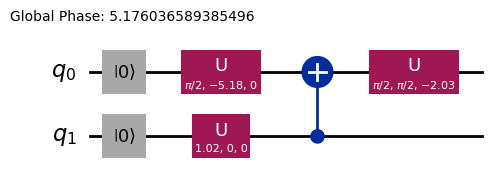

In [15]:
import math
M = [4, 8, 5]

alpha=0
for i in M:
    alpha+=i**2

print(alpha)

desired_state = [
    1/ math.sqrt(alpha) * 4,
    1/ math.sqrt(alpha) * 8,
    1/ math.sqrt(alpha) * 5,
    1/ math.sqrt(alpha) * 0
]

print(desired_state)

qc= QuantumCircuit(2)

qc.initialize(desired_state, [0, 1])

qc.decompose(reps=5).draw(output="mpl")

An advantage of amplitude encoding is the aforementioned requirement of only $\mathrm{log}_2(N)$ qubits to encode. However, subsequent algorithms must operate on the amplitudes of a quantum state, and methods to prepare and measure the quantum states tend not to be efficient.



#### Check your understanding

Read the questions below, think about your answers, then click the triangles to reveal the solutions.

<details>
  <summary>
    Write down the normalized state for encoding the following vector (made of two vectors from our example dataset):

    $\vec{x}=(9,8,6,2,9,2)$

    using amplitude encoding.
  </summary>

  **Answer:**

  To encode 6 numbers, we will need to have at least 6 available states on whose amplitudes we can encode. This will require 3 qubits. Using an unknown normalization factor $\alpha$, we can write this as:

  $$
  |\psi\rangle = \alpha(9|000\rangle+8|001\rangle+6|010\rangle+2|011\rangle+9|100\rangle+2|101\rangle+0|110\rangle+0|111\rangle)
  $$

  Note that

  $$
  \langle \psi|\psi\rangle = |\alpha|^2\times(9^2+8^2+6^2+2^2+9^2+2^2+0^2+0^2) = |\alpha|^2\times(270)=1 \rightarrow \alpha = \frac{1}{\sqrt{270}}
  $$

  So finally,

  $$
  |\psi\rangle = \frac{1}{\sqrt{270}}(9|000\rangle+8|001\rangle+6|010\rangle+2|011\rangle+9|100\rangle+2|101\rangle+0|110\rangle+0|111\rangle)
  $$
</details>

<details>
  <summary>
    For the same data vector $\vec{x}=(9,8,6,2,9,2),$ write code to create a circuit that loads these data features using amplitude encoding.
  </summary>

  **Answer:**

  ```
  desired_state = [
      9 / math.sqrt(270),
      8 / math.sqrt(270),
      6 / math.sqrt(270),
      2 / math.sqrt(270),
      9 / math.sqrt(270),
      2 / math.sqrt(270),
      0,
      0,
  ]

  print(desired_state)

  qc = QuantumCircuit(3)
  qc.initialize(desired_state, [0, 1, 2])
  qc.decompose(reps=8).draw(output="mpl")
  ```

  \[0.5477225575051662, 0.48686449556014766, 0.36514837167011077, 0.12171612389003691, 0.5477225575051662, 0.12171612389003691, 0, 0]

  !["Output of the previous code cell"](/learning/images/courses/quantum-machine-learning/data-encoding/checkin2.avif)
</details>

<details>
  <summary>
    You may need to deal with very large data vectors. Consider the vector

    $$
    \vec{x}=(4,8,5,9,8,6,2,9,2,5,7,0,3,7,5).
    $$

    Write code to automate the normalization, and generate a quantum circuit for amplitude encoding.
  </summary>

  **Answer:**

  There are many possible answers. Here is code that prints a few steps along the way:

  ```
  import numpy as np
  from math import sqrt

  init_list = [4, 8, 5, 9, 8, 6, 2, 9, 2, 5, 7, 0, 3, 7, 5]
  qubits = round(np.log(len(init_list)) / np.log(2) + 0.4999999999)
  need_length = 2**qubits
  pad = need_length - len(init_list)
  for i in range(0, pad):
      init_list.append(0)

  init_array = np.array(init_list)  # Unnormalized data vector
  length = sqrt(
      sum(init_array[i] ** 2 for i in range(0, len(init_array)))
  )  # Vector length
  norm_array = init_array / length  # Normalized array
  print("Normalized array:")
  print(norm_array)
  print()

  qubit_numbers = []
  for i in range(0, qubits):
      qubit_numbers.append(i)
  print(qubit_numbers)

  qc = QuantumCircuit(qubits)
  qc.initialize(norm_array, qubit_numbers)
  qc.decompose(reps=7).draw(output="mpl")
  ```

  Normalized array:
  \[0.17342199 0.34684399 0.21677749 0.39019949 0.34684399 0.26013299
  0.086711   0.39019949 0.086711   0.21677749 0.30348849 0.
  0.1300665  0.30348849 0.21677749 0.        ]

  \[0, 1, 2, 3]

  !["Output of the previous code cell"](/learning/images/courses/quantum-machine-learning/data-encoding/checkin3.avif)
</details>

<details>
  <summary>
    Do you see advantages to amplitude encoding over basis encoding? If so, explain.
  </summary>

  **Answer:**

  There may be several answers. One answer is that, given the fixed ordering of the basis states, this amplitude encoding preserves the order of the numbers encoded. It will often also be encoded more densely.
</details>



A benefit of amplitude encoding is that only $\log_2(N)$ qubits are required for an $N$-dimensional ($N$-feature) data vector $\vec{x}\rightarrow|\vec{x}\rangle$. However, amplitude encoding is generally an inefficient procedure that requires arbitrary state preparation, which is exponential in the number of CNOT gates. Stated differently, the state preparation has a polynomial runtime complexity of $\mathcal O(N)$ in the number of dimensions, where $N = 2^n$, and $n$ is the number of qubits. Amplitude encoding “provides an exponential saving in space at the cost of an exponential increase in time”[\[3\]](#references); however, runtime increases to $\mathcal O(\log N)$ are achievable in certain cases[\[4\]](#references). For an end-to-end quantum speedup, the data loading runtime complexity needs to be considered.



### Angle encoding

Angle encoding is of interest in many QML models using Pauli feature maps such as quantum support vector machines (QSVMs) and variational quantum circuits (VQCs), among others. Angle encoding is closely related to phase encoding and dense angle encoding which are presented below. Here we will use "angle encoding" to refer to a rotation in $\theta$, that is, a rotation away from the $z$ axis accomplished for example by an $R_X$ gate or an $R_Y$ gate[\[1,3\]](#references). Really, one can encode data in *any* rotation or combination of rotations. But $R_Y$ is common in the literature, so we emphasize it here.

When applied to a single qubit, angle encoding imparts a Y-axis rotation proportional to the data value. Consider the encoding of a single ($k^\text{th}$)feature from the $j^\text{th}$ data vector in a dataset, $\vec{x}^{(j)}_k$:

$$
|\vec{x}^{(j)}_k\rangle = R_Y(\theta=\vec{x}^{(j)}_k)|0\rangle = \textstyle\cos\left(\frac{\vec{x}^{(j)}_k}{2}\right)|0\rangle + \sin\left(\frac{\vec{x}^{(j)}_k}{2}\right)|1\rangle.
$$

Alternatively, angle encoding can be performed using $R_X(\theta)$ gates, although the encoded state would have a complex relative phase compared to $R_Y(\theta)$.

Angle encoding is different from the previous two methods discussed in several ways. In angle encoding:

*   Each feature value is mapped to a corresponding qubit, $\vec{x}^{(j)}_k \rightarrow Q_k$, leaving the qubits in a product state.
*   One numerical value is encoded at a time, rather than a whole set of features from a data point.
*   $n$ qubits are required for $N$ data features, where $n\leq N$. Often equality holds, here. We'll see how $n<N$ is possible in the next few sections.
*   The resulting circuit is a constant depth (typically the depth is 1 prior to transpilation).

The constant depth quantum circuit makes it particularly amenable to current quantum hardware. One additional feature of encoding our data using $\theta$ (and specifically, our choice to use Y-axis angle encoding) is that it creates real-valued quantum states that can be useful for certain applications. For Y-axis rotation, data is mapped with a Y-axis rotation gate $R_Y(\theta)$ by a real-valued angle $\theta \in (0, 2\pi]$ ([Qiskit RYGate](/docs/api/qiskit/qiskit.circuit.library.RYGate)). As with phase encoding (see below), we recommend that you rescale data so that $\vec{x}^{(j)}_k \in (0,2\pi]$, preventing information loss and other unwanted effects.

The following Qiskit code rotates a single qubit from an initial state $|0\rangle$ to encode a data value $\vec{x}^{(j)}_k=\frac{1}{2}\pi$.



In [38]:
from qiskit.quantum_info import Statevector
from math import pi

qc = QuantumCircuit(1)
state1 = Statevector.from_instruction(qc)
qc.ry(pi / 2, 0)  # Phase gate rotates by an angle pi/2
state2 = Statevector.from_instruction(qc)
states = state1, state2

## Practice

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

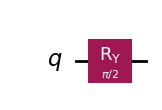

In [14]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from math import pi

qc= QuantumCircuit(1) # You create a circuit with 1 qubit, by default  the qubit starts in the |0> state
state1 = Statevector.from_instruction(qc)
display(state1.draw("latex"))

qc.ry(pi/2, 0) # Rotate qubit around Y-axis by π/2

state2 = Statevector.from_instruction(qc)
display(state2.draw("latex"))

display(qc.draw("mpl"))

states= state1, state2

We will define a function to visualize the action on the state vector. The details of the function definition are not important, but the ability to visualize the state vectors and their changes is important.



In [ ]:
import numpy as np
from qiskit.visualization.bloch import Bloch
from qiskit.visualization.state_visualization import _bloch_multivector_data


def plot_Nstates(states, axis, plot_trace_points=True):
    """This function plots N states to 1 Bloch sphere"""
    bloch_vecs = [_bloch_multivector_data(s)[0] for s in states]

    if axis is None:
        bloch_plot = Bloch()
    else:
        bloch_plot = Bloch(axes=axis)

    bloch_plot.add_vectors(bloch_vecs)

    if len(states) > 1:

        def rgba_map(x, num):
            g = (0.95 - 0.05) / (num - 1)
            i = 0.95 - g * num
            y = g * x + i
            return (0.0, y, 0.0, 0.7)

        num = len(states)
        bloch_plot.vector_color = [rgba_map(x, num) for x in range(1, num + 1)]

    bloch_plot.vector_width = 3
    bloch_plot.vector_style = "simple"

    if plot_trace_points:

        def trace_points(bloch_vec1, bloch_vec2):
            # bloch_vec = (x,y,z)
            n_points = 15
            thetas = np.arccos([bloch_vec1[2], bloch_vec2[2]])
            phis = np.arctan2(
                [bloch_vec1[1], bloch_vec2[1]], [bloch_vec1[0], bloch_vec2[0]]
            )
            if phis[1] < 0:
                phis[1] = phis[1] + 2 * pi
            angles0 = np.linspace(phis[0], phis[1], n_points)
            angles1 = np.linspace(thetas[0], thetas[1], n_points)

            xp = np.cos(angles0) * np.sin(angles1)
            yp = np.sin(angles0) * np.sin(angles1)
            zp = np.cos(angles1)
            pnts = [xp, yp, zp]
            bloch_plot.add_points(pnts)
            bloch_plot.point_color = "k"
            bloch_plot.point_size = [4] * len(bloch_plot.points)
            bloch_plot.point_marker = ["o"]

        for i in range(len(bloch_vecs) - 1):
            trace_points(bloch_vecs[i], bloch_vecs[i + 1])

    bloch_plot.sphere_alpha = 0.05
    bloch_plot.frame_alpha = 0.15
    bloch_plot.figsize = [4, 4]

    bloch_plot.render()


plot_Nstates(states, axis=None, plot_trace_points=True)

<Image src="/learning/images/courses/quantum-machine-learning/data-encoding/extracted-outputs/666700f7-7798-43ce-a8ca-d91e48adda4f-0.avif" alt="Output of the previous code cell" />

###  Practice

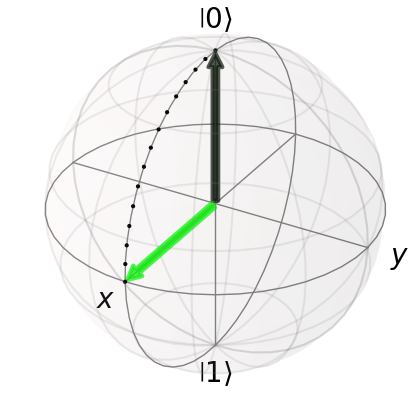

In [7]:
import numpy as np
from qiskit.visualization.bloch import Bloch
from qiskit.visualization.state_visualization import _bloch_multivector_data


def plot_Nstates(states, axis, plot_trace_points=True):
    """This function plots N states to 1 Bloch sphere"""
    bloch_vecs = [_bloch_multivector_data(s)[0] for s in states]

    if axis is None:
        bloch_plot = Bloch()
    else:
        bloch_plot = Bloch(axes=axis)

    bloch_plot.add_vectors(bloch_vecs)

    if len(states) > 1:

        def rgba_map(x, num):
            g = (0.95 - 0.05) / (num - 1)
            i = 0.95 - g * num
            y = g * x + i
            return (0.0, y, 0.0, 0.7)

        num = len(states)
        bloch_plot.vector_color = [rgba_map(x, num) for x in range(1, num + 1)]

    bloch_plot.vector_width = 3
    bloch_plot.vector_style = "simple"

    if plot_trace_points:

        def trace_points(bloch_vec1, bloch_vec2):
            # bloch_vec = (x,y,z)
            n_points = 15
            thetas = np.arccos([bloch_vec1[2], bloch_vec2[2]])
            phis = np.arctan2(
                [bloch_vec1[1], bloch_vec2[1]], [bloch_vec1[0], bloch_vec2[0]]
            )
            if phis[1] < 0:
                phis[1] = phis[1] + 2 * pi
            angles0 = np.linspace(phis[0], phis[1], n_points)
            angles1 = np.linspace(thetas[0], thetas[1], n_points)

            xp = np.cos(angles0) * np.sin(angles1)
            yp = np.sin(angles0) * np.sin(angles1)
            zp = np.cos(angles1)
            pnts = [xp, yp, zp]
            bloch_plot.add_points(pnts)
            bloch_plot.point_color = "k"
            bloch_plot.point_size = [4] * len(bloch_plot.points)
            bloch_plot.point_marker = ["o"]

        for i in range(len(bloch_vecs) - 1):
            trace_points(bloch_vecs[i], bloch_vecs[i + 1])

    bloch_plot.sphere_alpha = 0.05
    bloch_plot.frame_alpha = 0.15
    bloch_plot.figsize = [4, 4]

    bloch_plot.render()


plot_Nstates(states, axis=None, plot_trace_points=True)

That was just a single feature of a single data vector. When encoding $N$ features into the rotation angles of $n$ qubits, say for the $j^\text{th}$ data vector $\vec{x}^{(j)} = (x_1,...,x_N),$ the encoded product state will look like this:

$$
|\vec{x}^{(j)}\rangle = \bigotimes^N_{k=1} \cos(\vec{x}^{(j)}_k)|0\rangle + \sin(\vec{x}^{(j)}_k)|1\rangle
$$

We note that this is equivalent to

$$
|\vec{x}^{(j)}\rangle = \bigotimes^N_{k=1} R_Y(2\vec{x}^{(j)}_k)|0\rangle.
$$

#### Check your understanding

Read the questions below, think about your answers, then click the triangles to reveal the solutions.

<details>
  <summary>
    Encode the data vector $\vec{x} = (0, \pi/4, \pi/2)$ using angle encoding, as described above.
  </summary>

  **Answer:**

  ```
  qc = QuantumCircuit(3)
  qc.ry(0, 0)
  qc.ry(2 * math.pi / 4, 1)
  qc.ry(2 * math.pi / 2, 2)
  qc.draw(output="mpl")
  ```

  !["Output of the previous code cell"](/learning/images/courses/quantum-machine-learning/data-encoding/checkin4.avif)
</details>

<details>
  <summary>
    Using angle encoding as described above, how many qubits are required to encode 5 features?
  </summary>

  **Answer:** 5
</details>



### Practice
Encode the data vector x=(0,π/4,π/2) using angle encoding

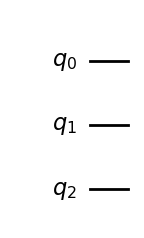

<IPython.core.display.Latex object>

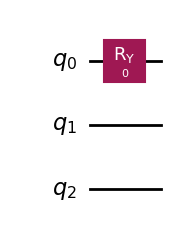

<IPython.core.display.Latex object>

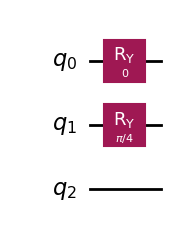

<IPython.core.display.Latex object>

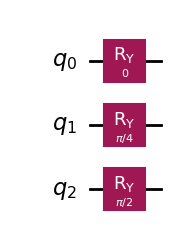

<IPython.core.display.Latex object>

In [15]:
import math
qc=QuantumCircuit(3)
display(qc.draw("mpl"))
state1 = Statevector.from_instruction(qc)
display(state1.draw("latex"))

qc.ry(0,0)
display(qc.draw("mpl"))
state2 = Statevector.from_instruction(qc)
display(state2.draw("latex"))

qc.ry(math.pi/4, 1)
display(qc.draw("mpl"))
state3 = Statevector.from_instruction(qc)
display(state3.draw("latex"))

qc.ry(math.pi/2, 2)
display(qc.draw("mpl"))
state3 = Statevector.from_instruction(qc)
display(state3.draw("latex"))

### Phase encoding

Phase encoding is very similar to the angle encoding described above. The phase angle of a qubit is a real-valued angle $\phi$ about the $z$-axis from the +$x$-axis. Data are mapped with a phase rotation, $P(\phi) = e^{i\phi/2}R_Z(\phi)$, where $\phi \in (0,2\pi]$ (see [Qiskit PhaseGate](/docs/api/qiskit/qiskit.circuit.library.PhaseGate) for more information). It is recommended to rescale data so that $\vec{x}^{(j)}_k \in (0,2\pi]$. This prevents information loss and other potentially unwanted effects[\[1,2\]](#references).

A qubit is often initialized in the state $|0\rangle$, which is an eigenstate of the phase rotation operator, meaning that the qubit state first needs to be rotated for phase encoding to be implemented. It therefore makes sense to initialize the state with a Hadamard gate: $H|0\rangle = |+\rangle = \textstyle\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$. Phase encoding on a single qubit means imparting a relative phase proportional to the data value:

$$
|\vec{x}^{(j)}_k\rangle = P(\phi=\vec{x}^{(j)}_k)|+\rangle = \textstyle\frac{1}{\sqrt{2}}\big(|0\rangle + e^{i\vec{x}^{(j)}_k}|1\rangle\big).
$$

The phase encoding procedure maps each feature value to the phase of a corresponding qubit, $\vec{x}^{(j)}_k \rightarrow Q_k$. In total, phase encoding has a circuit depth of 2, including the Hadamard layer, which makes it an efficient encoding scheme. The phase-encoded multi-qubit state ($n$ qubits for $N=n$ features) is a product state:

$$
|\vec{x}^{(j)}\rangle = \bigotimes_{k=1}^{N} P_k(\phi = \vec{x}^{(j)}_k)|+\rangle^{\otimes N} = {\textstyle\frac{1}{\sqrt{2^N}}} \bigotimes_{k=1}^{N}\big(|0\rangle + e^{i\vec{x}^{(j)}_k}|1\rangle\big).
$$

The following Qiskit code first prepares the initial state of a single qubit by rotating it with a Hadamard gate, then rotates it again using a phase gate to encode a data feature $\vec{x}^{(j)}_k=\frac{1}{2}\pi$.



In [41]:
qc = QuantumCircuit(1)
qc.h(0)  # Hadamard gate rotates state down to Bloch equator
state1 = Statevector.from_instruction(qc)

qc.p(pi / 2, 0)  # Phase gate rotates by an angle pi/2
state2 = Statevector.from_instruction(qc)

states = state1, state2

qc.draw("mpl", scale=1)

<Image src="/learning/images/courses/quantum-machine-learning/data-encoding/extracted-outputs/ba0886eb-1c56-4b15-a731-d94d805254e1-0.avif" alt="Output of the previous code cell" />

We can visualize the rotation in $\phi$ using the plot\_Nstates function we defined.



In [42]:
plot_Nstates(states, axis=None, plot_trace_points=True)

<Image src="/learning/images/courses/quantum-machine-learning/data-encoding/extracted-outputs/f7c9cf29-2ad6-43af-a7e3-e590e41d7e67-0.avif" alt="Output of the previous code cell" />

### Practice

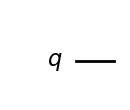

<IPython.core.display.Latex object>

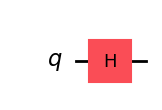

<IPython.core.display.Latex object>

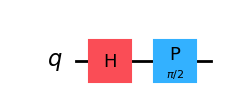

<IPython.core.display.Latex object>

In [22]:
qc = QuantumCircuit(1)

display(qc.draw("mpl"))
state1 = Statevector.from_instruction(qc)
display(state1.draw("latex"))


# Apply hadamard gate rotates state down to Bloach equater

qc.h(0)
state2 =Statevector.from_instruction(qc)
display(qc.draw("mpl"))
display(state2.draw("latex"))

qc.p(pi/2, 0) # Phase gate rotates by an angle pi/2
state3 =Statevector.from_instruction(qc)
display(qc.draw("mpl"))
display(state3.draw("latex"))

states = state1, state2


The Bloch sphere plot shows the Z-axis rotation $|+\rangle \rightarrow P(\frac{1}{2}\pi)|+\rangle$ where $\vec{x}^{(j)}_k=\frac{1}{2}\pi$. The light green arrow shows the final state.

Phase encoding is used in many quantum feature maps, particularly $Z$ and $ZZ$ feature maps, and general Pauli feature maps, among others.



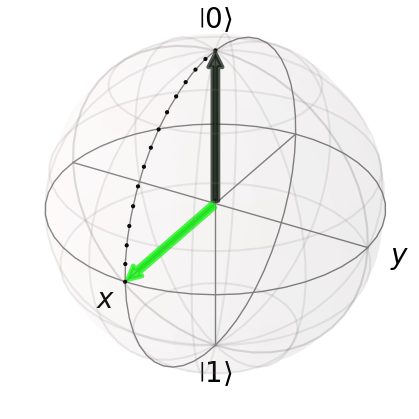

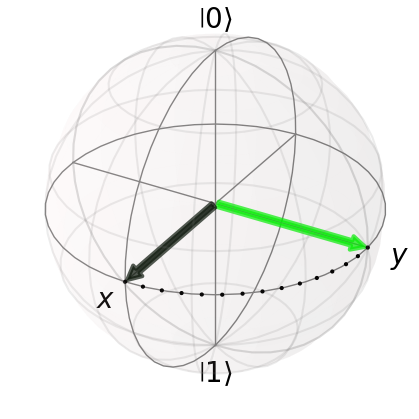

In [28]:
plot_Nstates((state1, state2), axis=None, plot_trace_points=True)
plot_Nstates((state2, state3), axis=None, plot_trace_points=True)

#### Check your understanding

Read the questions below, think about your answers, then click the triangles to reveal the solutions.

<details>
  <summary>
    How many qubits are required in order to use phase encoding as described above to store 8 features?
  </summary>

  **Answer:** 8
</details>

<details>
  <summary>
    Write code to the vector $\vec{x}^{(1)}=(4,8,5,9,8,6,2,9,2,5,7,0)$ using phase encoding.
  </summary>

  **Answer:**

  There may be many answers. Here is one example:

  ```
  phase_data = [4, 8, 5, 9, 8, 6, 2, 9, 2, 5, 7, 0]
  qc = QuantumCircuit(len(phase_data))
  for i in range(0, len(phase_data)):
      qc.h(i)
      qc.rz(phase_data[i] * 2 * math.pi / float(max(phase_data)), i)
  qc.draw(output="mpl")
  ```

  !["Output of the previous code cell"](/learning/images/courses/quantum-machine-learning/data-encoding/checkin5.avif)
</details>



## Practice

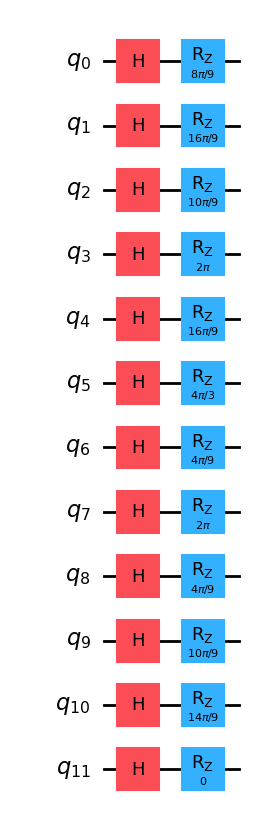

In [29]:
phase_data = [4, 8, 5, 9, 8, 6, 2, 9, 2, 5, 7, 0]

qc = QuantumCircuit(len(phase_data))

for i in range(0, len(phase_data)):
    qc.h(i)
    qc.rz(phase_data[i]* 2 * math.pi / float(max(phase_data)), i)

qc.draw(output="mpl")

### Dense angle encoding

Dense angle encoding (DAE) is a combination of angle encoding and phase encoding. DAE allows two feature values to be encoded in a single qubit: one angle with a Y-axis rotation angle, and the other with a $z$-axis rotation angle: $\vec{x}^{(j)}_k,$ $\vec{x}^{(j)}_\ell \rightarrow \theta, \phi$. It encodes two features as follows:

$$
|\vec{x}^{(j)}_k,\vec{x}^{(j)}_\ell\rangle = R_Z(\phi=\vec{x}^{(j)}_\ell) R_Y(\theta=\vec{x}^{(j)}_k)|0\rangle = \cos\left(\frac{\vec{x}^{(j)}_k}{2}\right)|0\rangle + e^{i\vec{x}^{(j)}_\ell} \sin\left(\frac{\vec{x}^{(j)}_k}{2}\right)|1\rangle.
$$

Encoding two data features to one qubit results in a $2\times$ reduction in the number of qubits required for the encoding. Extending this to more features, the data vector $\vec{x} = (x_1,...,x_N)$ can be encoded as:

$$
|\vec{x}\rangle = \bigotimes_{k=1}^{N/2} \cos(x_{2k-1})|0\rangle + e^{i x_{2k}}\sin(x_{2k-1})|1\rangle
$$

DAE can be generalized to arbitrary functions of the two features instead of the sinusoidal functions used here. This is called general qubit encoding[\[7\]](#references).

As an example of DAE, the code below encodes and visualizes the encoding of the features $x_1=\theta = 3\pi/8$ and $x_2=\phi = 7\pi/4$.



In [44]:
qc = QuantumCircuit(1)
state1 = Statevector.from_instruction(qc)
qc.ry(3 * pi / 8, 0)
state2 = Statevector.from_instruction(qc)
qc.rz(7 * pi / 4, 0)
state3 = Statevector.from_instruction(qc)
states = state1, state2, state3

plot_Nstates(states, axis=None, plot_trace_points=True)

<Image src="/learning/images/courses/quantum-machine-learning/data-encoding/extracted-outputs/9a6bb041-d7a1-4e29-a463-81b93b900e96-0.avif" alt="Output of the previous code cell" />

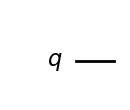

<IPython.core.display.Latex object>

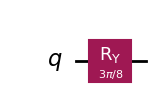

<IPython.core.display.Latex object>

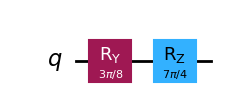

<IPython.core.display.Latex object>

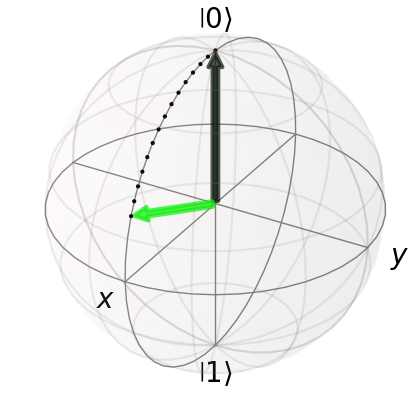

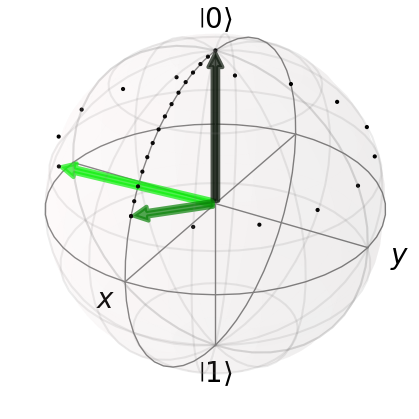

In [34]:
qc = QuantumCircuit(1)
state1 = Statevector.from_instruction(qc)
display(qc.draw("mpl"))
display(state1.draw("latex"))

qc.ry(3 * pi / 8, 0)
state2 = Statevector.from_instruction(qc)
display(qc.draw("mpl"))
display(state2.draw("latex"))

qc.rz(7 * pi / 4, 0)
state3 = Statevector.from_instruction(qc)
display(qc.draw("mpl"))
display(state3.draw("latex"))

statesa = state1, state2

statesb = state1, state2, state3

plot_Nstates(statesa, axis=None, plot_trace_points=True)

plot_Nstates(statesb, axis=None, plot_trace_points=True)


#### Check your understanding

Read the questions below, think about your answers, then click the triangles to reveal the solutions.

<details>
  <summary>
    Given the treatment above, how many qubits are needed to encode 6 features using dense encoding?
  </summary>

  **Answer:** 3
</details>

<details>
  <summary>
    Write code to load the vector $\vec{x}^{(1)}=(4,8,5,9,8,6,2,9,2,5,7,0,3,7,5)$ using dense angle encoding.
  </summary>

  **Answer:**

  Note that we have padded the list with a "0" to avoid the problem of there being a single unused parameter in our encoding scheme.

  ```
  dense_data = [4, 8, 5, 9, 8, 6, 2, 9, 2, 5, 7, 0, 3, 7, 5, 0]
  qc = QuantumCircuit(int(len(dense_data) / 2))
  entry = 0
  for i in range(0, int(len(dense_data) / 2)):
      qc.ry(dense_data[entry] * 2 * math.pi / float(max(dense_data)), i)
      entry = entry + 1
      qc.rz(dense_data[entry] * 2 * math.pi / float(max(dense_data)), i)
      entry = entry + 1
  qc.draw(output="mpl")
  ```

  !["Output of the previous code cell"](/learning/images/courses/quantum-machine-learning/data-encoding/checkin6.avif)
</details>



### Practice

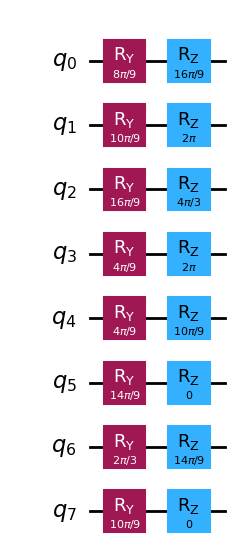

In [40]:
dense_data = [ 4, 8, 5, 9, 8, 6, 2, 9, 2, 5, 7, 0, 3, 7, 5, 0]
qc = QuantumCircuit(int(len(dense_data) / 2))

entry = 0
for i in range(0, int(len(dense_data) / 2)):
    qc.ry(dense_data[entry] * 2 * math.pi / float(max(dense_data)), i)
    entry = entry + 1
    qc.rz(dense_data[entry] * 2 * math.pi / float (max(dense_data)), i)
    entry = entry + 1
qc.draw(output="mpl")


## Encoding with built-in feature maps

### Encoding at arbitrary points

Angle encoding, phase encoding, and dense encoding prepared product states with a feature encoded on each qubit (or two features per qubit). This is different from basis encoding and amplitude encoding, in that those methods make use of entangled states. There is not a 1:1 correspondence between data feature and qubit. In amplitude encoding, for example, you might have one feature as the amplitude of the state $|01\rangle$ and another feature as the amplitude for $|10\rangle$. Generally, methods that encode in product states yield shallower circuits and can store 1 or 2 features on each qubit. Methods that use entanglement and associate a feature with a state rather than a qubit result in deeper circuits, and can store more features per qubit on average.

But encoding need not be entirely in product states or entirely in entangled states as in amplitude encoding. Indeed, many encoding schemes built into Qiskit allow encoding both before and after an entanglement layer, as opposed to just at the beginning. This is known as "data reuploading". For related work, see references \[5] and  \[6].

In this section, we will use and visualize a few of the built-in encoding schemes. All the methods in this section encode $N$ features as rotations on $N$ parameterized gates on $n$ qubits, where $n \leq N$. Note that maximizing data loading for a given number of qubits is not the only consideration. In many cases, circuit depth may be an even more important consideration than qubit count.



### Efficient SU2

A common and useful example of encoding with entanglement is Qiskit's [`efficient_su2`](/docs/api/qiskit/qiskit.circuit.library.EfficientSU2) circuit. Impressively, this circuit can, for example, encode 8 features on only 2 qubits. Let's see this, and then try to understand how it is possible.



In [46]:
from qiskit.circuit.library import efficient_su2

circuit = efficient_su2(num_qubits=2, reps=1, insert_barriers=True)
circuit.decompose().draw(output="mpl")

<Image src="/learning/images/courses/quantum-machine-learning/data-encoding/extracted-outputs/6b657226-ae95-41f6-b78b-5def930d0080-0.avif" alt="Output of the previous code cell" />

## Practice 

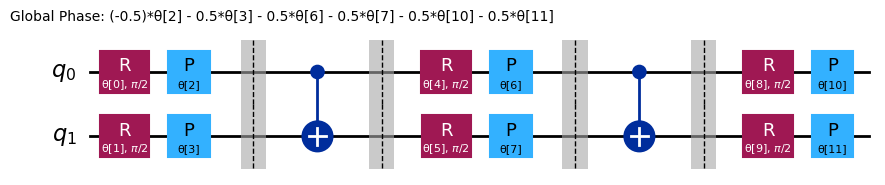

In [42]:
from qiskit.circuit.library import efficient_su2

circuit = efficient_su2(num_qubits=2, reps=2, insert_barriers=True)
circuit.decompose().draw(output="mpl")

As we write our state, we will use the Qiskit convention that least-significant qubits are ordered to the far right, as in $|q_2,q_1,q_0\rangle$ or $|q_2\rangle\otimes|q_1\rangle\otimes|q_0\rangle.$ These states can become very complicated very quickly, and this rare example may help explain why such states are seldom written out explicitly.

Our system starts in the state $|00\rangle.$ Up to the first barrier (a point we label $b1$), our states are:

$$
|\psi\rangle_{b1} = \left(\cos\left(\frac{\theta_1}{2}\right)|0\rangle+\sin\left(\frac{\theta_1}{2}\right)e^{i\theta_3}|1\rangle\right)\otimes\left(\cos\left(\frac{\theta_0}{2}\right)|0\rangle+\sin\left(\frac{\theta_0}{2}\right)e^{i\theta_2}|1\rangle\right)
$$

That's just dense encoding, which we've seen before. Now after the CNOT gate, at the second barrier ($b2$), our state is



$$
\begin{aligned}
|\psi\rangle_{b2} = & \cos\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_0}{2}\right)|00\rangle+\cos\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_0}{2}\right)e^{i\theta_2}|11\rangle\\
+ & \sin\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_0}{2}\right)e^{i\theta_3}|10\rangle+\sin\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_0}{2}\right)e^{i\theta_2}e^{i\theta_3}|01\rangle
\end{aligned}
$$



We now apply the last set of single-qubit rotations and collect like states to obtain:



$$
\begin{align*}
|\psi\rangle_{\text{final}} = &
\left[\cos\left(\frac{\theta_0}{2}\right)\left(\cos\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_5}{2}\right)-\sin\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_5}{2}\right)e^{i\theta_3}\right)\cos\left(\frac{\theta_4}{2}\right)\right.\\

+ & \left.\sin\left(\frac{\theta_0}{2}\right)\left(\cos\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_5}{2}\right)-\sin\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_5}{2}\right)e^{i\theta_3}\right)\sin\left(\frac{\theta_4}{2}\right)e^{i\theta_2}\right]
|00\rangle\\

+ & \left[\cos\left(\frac{\theta_0}{2}\right)\left(\cos\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_5}{2}\right)-\sin\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_5}{2}\right)e^{i\theta_3}\right)\sin\left(\frac{\theta_4}{2}\right)\right.\\

+ & \left.\sin\left(\frac{\theta_0}{2}\right)\left(-\cos\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_5}{2}\right)+\sin\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_5}{2}\right)e^{i\theta_3}\right)\cos\left(\frac{\theta_4}{2}\right)e^{i\theta_2}\right]
e^{i\theta_6}|01\rangle\\

+ & \left[\cos\left(\frac{\theta_0}{2}\right)\left(\cos\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_5}{2}\right)+\sin\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_5}{2}\right)e^{i\theta_3}\right)\cos\left(\frac{\theta_4}{2}\right)\right.\\

- & \left.\sin\left(\frac{\theta_0}{2}\right)\left(\cos\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_5}{2}\right)+\sin\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_5}{2}\right)e^{i\theta_3}\right)\sin\left(\frac{\theta_4}{2}\right)e^{i\theta_2}\right]
e^{i\theta_7}|10\rangle\\

+ & \left[\cos\left(\frac{\theta_0}{2}\right)\left(\cos\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_5}{2}\right)+\sin\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_5}{2}\right)e^{i\theta_3}\right)\sin\left(\frac{\theta_4}{2}\right)\right.\\

+ & \left.\sin\left(\frac{\theta_0}{2}\right)\left(\cos\left(\frac{\theta_1}{2}\right)\cos\left(\frac{\theta_5}{2}\right)+\sin\left(\frac{\theta_1}{2}\right)\sin\left(\frac{\theta_5}{2}\right)e^{i\theta_3}\right)\cos\left(\frac{\theta_4}{2}\right)e^{i\theta_2}\right]
e^{i\theta_6}e^{i\theta_7}|11\rangle

\end{align*}
$$



This is likely too complicated to parse. Instead, just step back and think about how many parameters we loaded onto the state: eight. But we have with just four computational basis states. At first glance, it may appear that we have loaded more parameters than makes sense, since the final state can be written as $\psi_\text{final} = c_0|00\rangle+c_1|01\rangle+c_2|10\rangle+c_3|11\rangle$. Note, however, that each prefactor is complex! Written like this:

$$
\psi_\text{final} = (a_0+ib_0)|00\rangle+(a_1+ib_1)|01\rangle+(a_2+ib_2)|10\rangle+(a_3+ib_3)|11\rangle
$$

One can see that we do, indeed, have eight parameters on the state on which to encode our eight features.

By increasing the number of qubits and increasing the number of repetitions of entangling and rotation layers, one can encode much more data. Writing out the wave functions quickly becomes intractable. But we can still see the encoding in action.



Here we encode the data vector $\vec{x}$ with 12 features, on a 3-qubit `efficient_su2` circuit, using each of the parameterized gates to encode a different feature.

$$
\vec{x} = (0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2)
$$

In this data vector, the features are shown in a particular order. In isolation, it doesn't matter if they are encoded in this order or in the reverse. What is important is keeping track of it and being consistent. Note in the circuit diagram that `efficient_su2` assumes a certain ordering of encoding, specifically filling the first layer of parameterized gates from qubit 0 to qubit 2, and then moving to the next layer. This is neither consistent nor inconsistent with little-endian notation, since here the data features cannot be ordered by qubit *a priori*, before an encoding circuit has been specified.



In [47]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
circuit = efficient_su2(num_qubits=3, reps=1, insert_barriers=True)
encode = circuit.assign_parameters(x)
encode.decompose().draw(output="mpl")

<Image src="/learning/images/courses/quantum-machine-learning/data-encoding/extracted-outputs/73fc00fe-b98f-4d63-a327-54958a8f5498-0.avif" alt="Output of the previous code cell" />

##  Practice

In [49]:
x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
circuit = efficient_su2(num_qubits=3, reps=1, insert_barriers=True)
encode = circuit.assign_parameters(x)
encode.decompose().draw(output="mpl")

state = Statevector.from_instruction(encode)

display(state.draw("latex"))


<IPython.core.display.Latex object>

Instead of increasing the number of qubits, you might choose to increase the number of repetitions of entangling and rotation layers. But there are limits to how many repetitions are useful.



As previously stated, there is a tradeoff: circuits with more qubits or more repetitions of entangling and rotation layers may store more parameters, but do so with greater circuit depth. We will return to the depths of some built-in feature maps, below.



The next few encoding methods that are built into Qiskit have "feature map" as part of their names. Let us reiterate that encoding data into a quantum circuit *is* a feature mapping, in the sense that it takes data into a new space: the Hilbert space of the qubits involved. The relationship between the dimensionality of the original feature space and that of the Hilbert space will depend on the circuit you use for encoding.



### $Z$ feature map

The $Z$ feature map (ZFM) can be interpreted as a natural extension of phase encoding. The ZFM consists of alternating layers of single-qubit gates: Hadamard gate layers and phase gate layers. Let the data vector $\vec{x}$ have $N$ features. The quantum circuit that performs the feature mapping is represented as a unitary operator that acts on the initial state:

$$
\mathscr{U}_{\text{ZFM}}(\vec{x})|0\rangle^{\otimes N}=|\phi(\vec{x})\rangle
$$

where $|0\rangle^{\otimes N}$ is the $N$-qubit ground state. This notation is used for consistency with reference [\[4\]](#references) Havlicek et al. The data features $x_i$ are mapped one-to-one with corresponding qubits. For example, if you have 8 features in a data vector, then you would use 8 qubits. The ZFM circuit is composed of $r$ repetitions of a subcircuit comprised of Hadamard gate layers and phase gate layers. A Hadamard layer is made up of a Hadamard gate acting on every qubit in an $n$-qubit register, $H \otimes H \otimes \dots \otimes H = H^{\otimes n}$, within the same stage of the algorithm. This description also applies to a phase gate layer in which the $i^\text{th}$ qubit is acted on by $P(\vec{x}_i)$. Each $P$ gate has one feature as an argument, but the phase gate layer ($P(\vec{x}_1)\otimes\ldots P(\vec{x}_k)\otimes\ldots P(\vec{x}_N)$ is a function of the data vector. The full ZFM circuit unitary with a single repetition is:

$$
\mathscr{U}_{\text{ZFM}}=\big(P(\vec{x}_1)\otimes\ldots P(\vec{x}_k)\otimes\ldots P(\vec{x}_N)H^{\otimes N}\big)=\left(\bigotimes_{k = 1}^N P(\vec{x}_k)\right)H^{\otimes N}
$$

Then $r$ repetitions of this unitary would be

$$
\mathscr{U}^{(r)}_{\text{ZFM}}\left(\vec{x}\right)=\prod_{s=1}^{r}\left[\left(\bigotimes_{k = 1}^N P(\vec{x}_k)\right)H^{\otimes N}\right]
$$

The data features, $x_k$, are mapped to the phase gates in the same way in all $r$ repetitions. The ZFM feature map state is a product state and is efficient for classical simulation[\[4\]](#references).

To start with a small example, a two-qubit ZFM circuit is coded using Qiskit and drawn to display the simple circuit structure. In the example, a single repetition, $r=1$, is implemented with the data vector $\vec{x} = \left(\textstyle\frac{1}{2}\pi, \textstyle\frac{1}{3}\pi\right)$. Note that this is written in the standard order of a vector in Python, meaning the $0^\text{th}$ element is $\textstyle\frac{1}{2}\pi.$ We are free to encode this $0^\text{th}$ feature onto our $0^\text{th}$ qubit, or onto our $N^\text{th}.$ Again, there cannot always be a single 1:1 mapping from feature order to qubit order, since different feature maps encode different numbers of features to each qubit. Again what is important is that we are aware of where each feature is being encoded. When providing a parameter list to the $Z$ feature map, it will encode feature 0 from the list to the least-significant qubit with a parameterized gate, as in qubit 0. So we will follow that convention when doing this by hand. We will encode $\textstyle\frac{1}{2}\pi$ on the $0^\text{th}$ qubit, and $\textstyle\frac{1}{3}\pi$ on the $1^\text{st}$ qubit.

The ZFM circuit unitary operator acts on the initial state in the following way:

$$
\mathscr{U}_{\text{ZFM}}(\bar{x})|00\rangle = P(\bar{x})^{\otimes 2} H^{\otimes 2}|00\rangle = \left( P\left(\textstyle\frac{1}{3}\pi\right)H|0\rangle \right) \otimes \left(P\left(\textstyle\frac{1}{2}\pi\right)H|0\rangle\right).
$$

The formula has been rearranged around the tensor product to emphasize the operations on each qubit. The following Qiskit code uses Hadamard and phase gates explicitly to show the structure of the ZFM:



In [48]:
qc0 = QuantumCircuit(1)
qc1 = QuantumCircuit(1)

qc0.h(0)
qc0.p(pi / 2, 0)

qc1.h(0)
qc1.p(pi / 3, 0)

# Combine circuits qc0 and qc1 into 1 circuit
qc = QuantumCircuit(2)
qc.compose(qc0, [0], inplace=True)
qc.compose(qc1, [1], inplace=True)

qc.draw("mpl", scale=1)

<Image src="/learning/images/courses/quantum-machine-learning/data-encoding/extracted-outputs/f5c70df4-faea-4817-a870-95638eb97dbd-0.avif" alt="Output of the previous code cell" />

We now encode the same data vector $\vec{x} = \left(\textstyle\frac{1}{2}\pi, \textstyle\frac{1}{3}\pi\right)$ to a ZFM circuit with three repetitions, $r=3$, using the Qiskit [`z_feature_map`](/docs/api/qiskit/qiskit.circuit.library.ZFeatureMap) class, which altogether gives us the quantum feature map $\mathscr{U}_{\text{ZFM}}(\vec{x})$. By default in the `z_feature_map` class, parameters $\beta$ are multiplied by 2 before mapping to the phase gate $\beta \rightarrow P(\theta = 2\beta)$. To reproduce the same encodings as above, we divide by 2.



In [49]:
from qiskit.circuit.library import z_feature_map

zfeature_map = z_feature_map(feature_dimension=2, reps=3)
zfeature_map = zfeature_map.assign_parameters([(1 / 2) * pi / 2, (1 / 2) * pi / 3])
zfeature_map.decompose().draw("mpl")

<Image src="/learning/images/courses/quantum-machine-learning/data-encoding/extracted-outputs/c15b8fe2-ae83-4c76-a908-71596deb7d82-0.avif" alt="Output of the previous code cell" />

Clearly this is a different mapping from the one done by hand above, but note the consistency in parameter ordering: $\textstyle\frac{1}{2}\pi$ was again encoded on the $0^\text{th}$ qubit.

You may use ZFM via Qiskit's ZFM class; you can also use this structure as inspiration to construct your own feature mapping.



### $ZZ$ feature map

The $ZZ$ feature map (ZZFM) extends the ZFM with the inclusion of two-qubit entangling gates, specifically the $ZZ$-rotation gate $R_{ZZ}(\theta)$. The ZZFM is conjectured to be generally expensive to compute on a classical computer, unlike the ZFM.

$R_{ZZ}(\theta)$ implements a $ZZ$-interaction and is maximally entangling for $\theta = \textstyle{\frac{1}{2}}\pi$. $R_{ZZ}(\theta)$ can be decomposed into a series of gates on two qubits, as shown in the following Qiskit code using the [RZZ gate](/docs/api/qiskit/qiskit.circuit.library.RZZGate) and the `QuantumCircuit` class method `decompose`. We encode a single feature of the data vector $\vec{x}$: $\vec{x}_k=\pi.$



In [50]:
qc = QuantumCircuit(2)
qc.rzz(pi, 0, 1)
qc.draw("mpl", scale=1)

<Image src="/learning/images/courses/quantum-machine-learning/data-encoding/extracted-outputs/6c312a5f-91a5-499c-a391-efc73cd0e4e1-0.avif" alt="Output of the previous code cell" />

As is often the case, we see this represented as a single gate-like unit, until we use .decompose() to see all constituent gates.



In [51]:
qc.decompose().draw("mpl", scale=1)

<Image src="/learning/images/courses/quantum-machine-learning/data-encoding/extracted-outputs/92062646-78f2-4dd6-82ad-7a543cb6a566-0.avif" alt="Output of the previous code cell" />

Data is mapped with a phase rotation $P(\theta) = e^{i\theta/2}R_Z(\theta)$ on the second qubit. The $R_{ZZ}(\theta)$ gate entangles the two qubits on which it operates by a degree of entanglement determined by the encoded feature value.

The full ZZFM circuit consists of a Hadamard gate and phase gate, as in the ZFM, followed by the entanglement described above. A single repetition of the ZZFM circuit is:

$$
\mathscr{U}_{\text{ZZFM}}(\vec{x}) = U_{ZZ}(\vec{x})\big(P(\vec{x}_1)\otimes\ldots P(\vec{x}_k)\otimes\ldots P(\vec{x}_N)H^{\otimes N}\big)=U_{ZZ}(\vec{x})\left(\bigotimes_{k = 1}^N P(\vec{x}_k)\right)H^{\otimes N},
$$

where $U_{ZZ}(\vec{x})$ contains ZZ-gate layer structured by an entanglement scheme. Several entanglement schemes are shown in code blocks below. The structure of $U_{ZZ}(\vec{x})$ also includes a function that combines the data features from qubits being entangled in the following way. Let us say that the $R_{ZZ}$ gate is to be applied to qubits $p$ and $q$. In the phase layer, these qubits have phase gates that encode $\vec{x}_p$ and $\vec{x}_q$ on them, respectively. The argument $\theta_{q,p}$ of the $R_{ZZ,q,p}(\theta_{q,p})$ will not simply be one of these features or the other, but a function often denoted by $\phi$ (not to be confused with the azimuthal angle):

$$
\theta_{q,p} \rightarrow \phi(\vec{x}_q, \vec{x}_p) = 2(\pi-\vec{x}_q)(\pi-\vec{x}_p).
$$

We will see this in several examples below. The extension to multiple repetitions is the same as in the `z_feature_map` case:

$$
\mathscr{U}^{(r)}_{\text{ZZFM}}\left(\vec{x}\right)=\prod_{s=1}^{r}\left[U_{ZZ}(\vec{x})\left(\bigotimes_{k = 1}^N P(\vec{x}_k)\right)H^{\otimes N}\right].
$$

As the operators have increased in complexity, let us first encode a data vector $\vec{x} = (x_0, x_1)$ with a two-qubit ZZFM and one repetition using the following code:



In [52]:
from qiskit.circuit.library import zz_feature_map

feature_dim = 2
zzfeature_map = zz_feature_map(
    feature_dimension=feature_dim, entanglement="linear", reps=1
)
zzfeature_map.decompose(reps=1).draw("mpl", scale=1)

<Image src="/learning/images/courses/quantum-machine-learning/data-encoding/extracted-outputs/1ec2f2e1-b665-4dde-a223-35489f17c695-0.avif" alt="Output of the previous code cell" />

By default in Qiskit, the features $(\vec{x}_1, \vec{x}_2)$ are mapped together to $R_{ZZ}(\theta)$ by this mapping function $\theta_{1,2} = \phi(\vec{x}_1, \vec{x}_2) = 2(\pi-\vec{x}_1)(\pi-\vec{x}_2)$. Qiskit allows the user to customize the function $\phi$ (or $\phi_S$ where $S$ is the set of qubit pairs coupled through $R_{ZZ}$ gates) as a preprocessing step.

Moving to a four-dimensional data vector $\vec{x} = (\vec{x}_1, \vec{x}_2, \vec{x}_3, \vec{x}_4)$ and mapping to a four-qubit ZZFM with one repetition, we can start to see the mapping $\phi$ for various qubit pairs. We can also see the meaning of "linear" entanglement:



In [53]:
feature_dim = 4
zzfeature_map = zz_feature_map(
    feature_dimension=feature_dim, entanglement="linear", reps=1
)
zzfeature_map.decompose().draw("mpl", scale=1)

<Image src="/learning/images/courses/quantum-machine-learning/data-encoding/extracted-outputs/979c765a-e3d8-4e3e-8e52-3f816203a934-0.avif" alt="Output of the previous code cell" />

In the linear entanglement scheme, nearest-neighbor (numbered) pairs of qubits in this circuit are entangled. There are other built-in entanglement schemes in Qiskit, including `circular` and `full`.



### Pauli feature map

The Pauli feature map (PFM) is the generalization of the ZFM and ZZFM to use arbitrary Pauli gates. The Pauli feature map takes a very similar form to the previous two feature maps. For $r$ repetitions of the encoding of the $N$ features of vector $\vec{x},$

$$
\mathscr{U}_{\text{PFM}}(\vec{x}) = \prod_{s=1}^{r} U(\vec{x}) H^{\otimes n}.
$$

For PFM, $U(\vec{x})$ is generalized to a Pauli expansion unitary operator. Here we present a more generalized form of the feature maps considered so far:

$$
U(\vec{x}) = \exp\left(i \sum_{S \in\mathcal{I}} \phi_S(\vec{x}) \prod_{i \in S} \sigma_i \right),
$$

where $\sigma_i$ is a Pauli operator, $\sigma_i \in {I,X,Y,Z}$. Here $\mathcal{I}$ is the set of all qubit connectivities as determined by the feature map, including the set of qubits acted on by single-qubit gates. That is, for a feature map in which qubit 0 was acted upon by a phase gate, and qubits 2 and 3 were acted upon by an $R_{ZZ}$ gate, the set $\mathcal{I}$ would include $\{\{0\},\{2,3\}\}$. $S$ runs through all elements of that set. In previous feature maps, the function $\phi_S(\vec{x})$ was involved either exclusively with single-qubit gates or exclusively with two-qubit gates. Here, we define it in general:

$$
\phi_S(\vec{x})=
    \begin{cases}
      x_i & \text{if } S= \{i\} \text{ (single-qubit)}\\
      \prod_{j\in{S}}(\pi-x_j) & \text{if } |S|\ge2 \text{ (multi-qubit)}\\
    \end{cases}
$$

For documentation, see the [Qiskit `Pauli feature map` class documentation](/docs/api/qiskit/qiskit.circuit.library.PauliFeatureMap)). In the ZZFM, the operator $\sigma_i$ is restricted to $Z_i$.

One way to understand the above unitary is through analogy with the propagator in a physical system. The unitary above is a unitary evolution operator, $\exp(it\mathcal{H})$, for a Hamiltonian, $\mathcal{H}$, similar to the Ising model, where the time parameter, $t$, is replaced with data values to drive the evolution. The expansion of this unitary operator gives the PFM circuit. The entangling connectivities in $S$ can be interpreted as Ising couplings in a spin lattice.



Let us consider an example of Pauli $Y$ and $XX$ operators representing those Ising-type interactions. Qiskit provides a `pauli_feature_map` class for instantiating a PFM with a choice of single- and $n$-qubit gates, which in this example will be passed as Pauli strings `‘Y’` and `‘XX’`. Typically, $n$ is 1 or 2 for single- and two-qubit interactions, respectively. The entanglement scheme is “linear,” meaning that only nearest-neighbor qubits in the quantum circuit are coupled. Note that this does not correspond to nearest-neighbor qubits on the quantum computer itself, as this quantum circuit is an abstraction layer.



In [54]:
from qiskit.circuit.library import pauli_feature_map

feature_dim = 3
pfmap = pauli_feature_map(
    feature_dimension=feature_dim, entanglement="linear", reps=1, paulis=["Y", "XX"]
)

pfmap.decompose().draw("mpl", scale=1.5)

<Image src="/learning/images/courses/quantum-machine-learning/data-encoding/extracted-outputs/5ba5df82-83c1-428c-a269-baea5f75c3dc-0.avif" alt="Output of the previous code cell" />

Qiskit provides a parameter, $\alpha$, in Pauli feature maps to control the scaling of Pauli rotations.

$$
U(\bar{x}) = \exp\left(i \alpha \sum_{S\subseteq[n]} \phi_S(\bar{x}) \prod_{i \in S} \sigma_i \right)
$$

The default value of $\alpha$ is $2$. By optimizing its value in the interval, for example, $[0,4],$ one can better align a quantum kernel to the data.



### Gallery of Pauli feature maps

Here we visualize various Pauli feature maps for two-qubit circuits to get a better picture of the range of possibilities.



In [55]:
from qiskit.visualization import circuit_drawer
import matplotlib.pyplot as plt

feature_dim = 2
fig, axs = plt.subplots(9, 2)
i_plot = 0
for paulis in [
    ["I"],
    ["X"],
    ["Y"],
    ["Z"],
    ["XX"],
    ["XY"],
    ["XZ"],
    ["YY"],
    ["YZ"],
    ["ZZ"],
    ["X", "ZZ"],
    ["Y", "ZZ"],
    ["Z", "ZZ"],
    ["X", "YZ"],
    ["Y", "YZ"],
    ["Z", "YZ"],
    ["YY", "ZZ"],
    ["XY", "ZZ"],
]:
    pfmap = pauli_feature_map(feature_dimension=feature_dim, paulis=paulis, reps=1)
    circuit_drawer(
        pfmap.decompose(),
        output="mpl",
        style={"backgroundcolor": "#EEEEEE"},
        ax=axs[int((i_plot - i_plot % 2) / 2), i_plot % 2],
    )
    axs[int((i_plot - i_plot % 2) / 2), i_plot % 2].title.set_text(paulis)
    i_plot += 1

fig.set_figheight(16)
fig.set_figwidth(16)

<Image src="/learning/images/courses/quantum-machine-learning/data-encoding/extracted-outputs/69225757-193a-490b-8ca4-d1b187b774b3-0.avif" alt="Output of the previous code cell" />

The above can, of course, be extended to include other permutations and repetitions of Pauli matrices. Learners are encouraged to experiment with those options.



## Review of built-in feature maps

You have seen several schemes for encoding data into a quantum circuit:

*   Basis encoding
*   Amplitude encoding
*   Angle encoding
*   Phase encoding
*   Dense encoding

You have seen how to construct your own feature maps using these encoding schemes, and you have seen four built-in feature maps which take advantage of angle and phase encoding:

*   Efficient SU2
*   Z feature map
*   ZZ feature map
*   Pauli feature map

These built-in feature maps differed from each other in several ways:

*   The depth for a given number of encoded features
*   The number of qubits required for a given number of features
*   The degree of entanglement (obviously related to the other differences)

The code below applies these four built-in feature maps to the encoding of a feature set, and plots the two-qubit depth of the resulting circuit. Since two-qubit error rates are much higher than single-qubit gate error rates, one might reasonably be most interested in the depth of two-qubit gates. In the code below, we obtain counts of all gates in a circuit by first decomposing the circuit and then using count\_ops(), as shown below. Here the two-qubit gates we are interested in are 'cx' gates:



In [ ]:
# Initializing parameters and empty lists for depths
x = [0.1, 0.2]
n_data = []
zz2gates = []
su22gates = []
z2gates = []
p2gates = []

# Generating feature maps
for n in range(3, 10):
    x.append(n / 10)
    zzcircuit = zz_feature_map(n, reps=1, insert_barriers=True)
    zcircuit = z_feature_map(n, reps=1, insert_barriers=True)
    su2circuit = efficient_su2(n, reps=1, insert_barriers=True)
    pcircuit = pauli_feature_map(n, reps=1, paulis=["XX"], insert_barriers=True)
    # Getting the cx depths
    zzcx = zzcircuit.decompose().count_ops().get("cx")
    zcx = zcircuit.decompose().count_ops().get("cx")
    su2cx = su2circuit.decompose().count_ops().get("cx")
    pcx = pcircuit.decompose().count_ops().get("cx")

    # Appending the cx gate counts to the lists. We shift the zz and pauli data points, because they overlap.
    n_data.append(n)
    zz2gates.append(zzcx - 0.5)
    z2gates.append(0)
    su22gates.append(su2cx)
    p2gates.append(pcx + 0.5)

# Plot the output
plt.plot(n_data, p2gates, "bo")
plt.plot(n_data, zz2gates, "ro")
plt.plot(n_data, su22gates, "yo")
plt.plot(n_data, z2gates, "go")
plt.ylabel("CX Gates")
plt.xlabel("Data elements")
plt.legend(["Pauli", "ZZ", "SU2", "Z"])
# plt.suptitle('zz_feature_map(n)')
plt.show()

Generally Pauli and ZZ feature maps will result in greater circuit depth and higher numbers of 2-qubit gates than `efficient_su2` and Z feature maps.

Because the feature maps built into Qiskit are widely applicable, we will often not need to design our own, especially in the learning phase. However, experts in quantum machine learning will likely return to the subject of designing their own feature mapping, as they tackle two complicated challenges:

1.  Modern hardware: the presence of noise and the large overhead of error-correcting code mean that present-day applications will need to consider things like hardware efficiency and minimizing two-qubit gate depth.

2.  Mappings that fit the problem at hand: It is one thing to say that the `zz_feature_map`, for example, is difficult to simulate classically, and therefore interesting. It is quite another thing for the `zz_feature_map` to be ideally suited to **your** machine learning task or data set. The performance of different parameterized quantum circuits on different types of data is an active area of investigation.

We close with a note on hardware efficiency.



## Hardware-efficient feature mapping

A hardware-efficient feature mapping is one that takes into account constraints of real quantum computers, in the interest of reducing noise and errors in the computation. When running quantum circuits on near-term quantum computers, there are many strategies to mitigate noise inherent to the hardware. One main strategy for hardware efficiency is the minimization of the depth of the quantum circuit so that noise and decoherence have less time to corrupt the computation. The depth of a quantum circuit is the number of time-aligned gate steps required to complete the entire computation (after circuit optimization)[\[5\]](#references). Recall that the depth of the abstract, logical circuit may be much lower than the depth once the circuit is transpiled for a real quantum computer.

Transpilation is the process of converting the quantum circuit from a high-level abstraction to one that is ready to run on a real quantum computer, taking into account constraints of the hardware. A quantum computer has a native set of single- and two-qubit gates. This means all gates in Qiskit code have to be transpiled into the set of native hardware gates. For example, in ibm\_torino, a QPU sporting a Heron r1 processor and completed in 2023, the native or basis gates are `{CZ, ID, RZ, SX, X}`. These are the two-qubit controlled-Z gate, and single-qubit gates called identity, $Z$-rotation, square root of NOT, and NOT, respectively, providing a universal set. When implementing multi-qubit gates as an equivalent subcircuit, physical two-qubit $CZ$ gates are required, along with other single-qubit gates available in hardware. In addition, to perform a two-qubit gate on a pair of qubits that are not physically coupled, SWAP gates are added to move qubit states between qubits to enable coupling, which leads to an unavoidable extension of the circuit. Using the `optimization` argument that can be set from 0 up to a highest level of 3. For greater control and customizability, the transpiler pipeline can be managed with the [Qiskit Pass Manager](/docs/api/qiskit/qiskit.transpiler.PassManager). Refer to the [Qiskit Transpiler documentation](/docs/api/qiskit/transpiler) for more information on transpilation.

In Havlicek et al. 2019 [\[2\]](#references), one way the authors achieve hardware efficiency is by using the $ZZ$ feature map because it is a second-order expansion (see the “$ZZ$ feature map” section above). An $N$-order expansion has $N$-qubit gates. IBM® quantum computers do not have native $N$-qubit gates, where $N>2$, so to implement them would require decomposition into two-qubit CNOT gates available in hardware. A second way the authors minimize depth is by choosing a $ZZ$ coupling topology that maps directly to the architecture couplings. A further optimization they undertake is targeting a higher-performing, suitably connected hardware subcircuit. Additional things to consider are minimizing the number of feature map repetitions and choosing a customized low-depth or “linear” entangling scheme instead of the “full” scheme that entangles all qubits.

![Data encoding image](/learning/images/courses/quantum-machine-learning/data-encoding/qml-03-data-encoding-24.avif)

The above graphic shows a network of nodes and edges that represent physical qubits and hardware couplings, respectively. The coupling map and performance of ibm\_torino is shown with all possible two-qubit CZ coupling gates. Qubits are color-coded on a scale based on the T1 relaxation time in microseconds (μs), where longer T1 times are better and in a lighter shade. The coupling edges are color-coded by CZ error, where darker shades are better. Information on the hardware specification can be accessed in the hardware backend configuration schema `IBMQBackend.configuration()`.



## References

1.  Maria Schuld and Francesco Petruccione, *Supervised Learning with Quantum Computers*, Springer 2018, [doi:10.1007/978-3-319-96424-9](https://www.springer.com/gp/book/9783319964232).
2.  <a id="Havlicek2018" />Vojtech Havlicek et al., “Supervised Learning with Quantum Enhanced Feature Spaces.” *Nature*, vol. 567 (2019): 209–212. [https://arxiv.org/abs/1804.11326](https://arxiv.org/abs/1804.11326).
3.  Ryan LaRose and Brian Coyle, "Robust data encodings for quantum classifiers", Physical Review A 102, 032420 (2020), [doi:10.1103/PhysRevA.102.032420](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.102.032420), [arXiv:2003.01695](https://arxiv.org/abs/2003.01695).
4.  <a id="Grover2002" />Lou Grover and Terry Rudolph. “Creating Superpositions That Correspond to Efficiently Integrable Probability Distributions.” arXiv:quant-ph/0208112, August 15, 2002, [https://arxiv.org/abs/quant-ph/0208112](https://arxiv.org/abs/quant-ph/0208112).
5.  Adrián Pérez-Salinas, Alba Cervera-Lierta, Elies Gil-Fuster, José I. Latorre, "Data re-uploading for a universal quantum classifier",  [Quantum 4, 226 (2020)](https://quantum-journal.org/papers/q-2020-02-06-226/), [ArXiv.org/abs/1907.02085](https://arxiv.org/abs/1907.02085).
6.  Maria Schuld, Ryan Sweke, Johannes Jakob Meyer, "The effect of data encoding on the expressive power of variational quantum machine learning models", [Phys. Rev. A 103, 032430 (2021)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.103.032430), [arxiv.org/abs/2008.08605](https://arxiv.org/abs/2008.08605)



In [ ]:
import qiskit

qiskit.version.get_version_info()

© IBM Corp., 2017-2026